In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import itertools
from decimal import Decimal
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec


MONGODB_SERVER = "localhost"
MONGODB_PORT = 27017

MONGODB_DB = "nba_odds_n_predict"
MONGODB_COLLECTION = "games_ah_odds"

In [2]:
def _connect_to_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)

    return conn[db]


def read_mongo_data_to_dataframe(db=MONGODB_DB, collection=MONGODB_COLLECTION, query={}, host=MONGODB_SERVER, port=MONGODB_PORT, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_to_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df = pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def map_team_to_id(teams_df, team_name):
    return teams_df[teams_df.FULL_TEAM_NAME == team_name].TEAM_ID.values[0]

def fraction2decimal(f):
    if f.find("/") != -1:
        return float(Decimal(f.split('/')[0]) / Decimal(f.split('/')[1])) + 1
    else:
        return f


def american2decimal(a):
    if a.find("+") != -1:
        return (float(a)/100) + 1
    elif a.find("-") != -1:
        return (100/abs(float(a))) + 1
    else:
        return a


def to_decimal(x):
    if x.find(".") != -1:
        return x
    elif x.find("/") != -1:
        return fraction2decimal(x)
    else:
        return american2decimal(x)


def calculate_payout(row, num=1):
    if float(row['sub_score']) >= (-1) * float(row['ah_'+str(num)]):
        home_win_with_ah = 1.0
    else:
        home_win_with_ah = 0.0
    if float(row['predict_subscore']) >= (-1) * float(row['ah_'+str(num)]):
        return (float(row['new_odd_home_'+str(num)]) * home_win_with_ah) - 1.0
    else:
        return (float(row['new_odd_away_'+str(num)]) * (1.0 - home_win_with_ah)) - 1.0

def calculate_payout_team(payout_df, team, home_game=True):
    if home_game:
        prefix = "home_team__"
    else:
        prefix = "away_team__"
    target_payout_df = payout_df[payout_df[prefix + team] == 1]
    return target_payout_df.payout_1.sum(), target_payout_df.payout_2.sum(),target_payout_df.payout_3.sum(),target_payout_df.payout_4.sum()

def predict_result(row, num=1):
    if float(row['sub_score']) >= (-1) * float(row['ah_'+str(num)]):
        home_win_with_ah = 1.0
    else:
        home_win_with_ah = 0.0
    if float(row['predict_subscore']) >= (-1) * float(row['ah_'+str(num)]):
        return 1 * home_win_with_ah
    else:
        return 1 * (1 - home_win_with_ah)


In [3]:
def read_n_preprocess_ah_df():
    ah_df = read_mongo_data_to_dataframe()
    ah_df = ah_df[ah_df.away_team != 'Team USA']
    ah_df = ah_df[ah_df.away_team != 'West']
    ah_df = ah_df[ah_df.home_team != 'Team World']
    ah_df = ah_df[ah_df.away_team != 'EAST']
    ah_df['winner'] = np.where(ah_df['score_home'] - ah_df['score_away'] > 0, 'home', 'away')
    ah_df['ot'] = ah_df['overtime'].apply(lambda x: 1 if x == True else 0)
    ah_df['home_win'] = ah_df['winner'].apply(lambda x: 1 if x == 'home' else 0)

    ah_df['date_time_DT'] = pd.to_datetime(ah_df['date_time'])
    ah_df['year'] = ah_df['date_time_DT'].dt.year.astype(int)
    ah_df['month'] = ah_df['date_time_DT'].dt.month.astype(int)
    ah_df['day'] = ah_df['date_time_DT'].dt.day.astype(int)
    ah_df['weekDay'] = ah_df['date_time_DT'].dt.dayofweek.astype(int)

    for i in range(1, 5):
        ah_df["new_odd_home_" + str(i)] = ah_df["odd_home_" + str(i)].apply(lambda x: to_decimal(x))
        ah_df["new_odd_away_" + str(i)] = ah_df["odd_away_" + str(i)].apply(lambda x: to_decimal(x))
        ah_df["new_odd_home_" + str(i)] = ah_df["new_odd_home_" + str(i)].astype(float)
        ah_df["new_odd_away_" + str(i)] = ah_df["new_odd_away_" + str(i)].astype(float)

    ah_df.drop(
        ['odd_home_1', 'odd_home_2', 'odd_home_3', 'odd_home_4', 'odd_away_1', 'odd_away_2', 'odd_away_3',
         'odd_away_4'],
        axis=1, inplace=True)

    one_hot = pd.get_dummies(ah_df[['away_team', 'home_team']], prefix=['away_team_', 'home_team_'])
    ah_df = ah_df.join(one_hot)
    ah_df.drop(['away_team', 'home_team'], axis=1, inplace=True)
    ah_df.drop(['date_time', 'date_time_DT', 'winner', 'overtime'], axis=1, inplace=True)

    ah_df['total_score'] = ah_df['score_home'] + ah_df['score_away']
    ah_df['sub_score'] = ah_df['score_home'] - ah_df['score_away']
    
    # ah_df['bet_winner'] = np.where(float(row['sub_score']) + float(row['ah_'+str(num)]) >= 0, 'home', 'away')

    ah_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    return ah_df

In [4]:
ah_df = read_n_preprocess_ah_df()

In [5]:
ah_df.head()

,ah_1,ah_2,ah_3,ah_4,odd_cnt_1,odd_cnt_2,odd_cnt_3,odd_cnt_4,score_away,score_home,...,home_team__Philadelphia_76ers,home_team__Phoenix_Suns,home_team__Portland_Trail_Blazers,home_team__Sacramento_Kings,home_team__San_Antonio_Spurs,home_team__Toronto_Raptors,home_team__Utah_Jazz,home_team__Washington_Wizards,total_score,sub_score
0,-5.0,-4.5,-6.0,-5.5,10,10,8,7,97,99,...,0,0,0,0,0,0,0,1,196,2
1,-7.0,-7.5,-6.5,-10.5,9,7,7,4,103,109,...,0,0,0,0,0,0,0,0,212,6
2,9.0,8.5,9.5,6.5,9,7,7,4,116,105,...,0,0,0,1,0,0,0,0,221,-11
3,14.5,15.0,13.5,15.5,9,8,4,4,111,80,...,0,0,0,0,0,0,0,0,191,-31
4,3.0,3.5,2.5,2.0,10,8,5,4,114,105,...,0,0,0,0,0,0,0,0,219,-9


In [6]:
COLUMNS = ['away_team__Atlanta_Hawks',
           'away_team__Boston_Celtics',
           'away_team__Brooklyn_Nets',
           'away_team__Charlotte_Hornets',
           'away_team__Chicago_Bulls',
           'away_team__Cleveland_Cavaliers',
           'away_team__Dallas_Mavericks',
           'away_team__Denver_Nuggets',
           'away_team__Detroit_Pistons',
           'away_team__Golden_State_Warriors',
           'away_team__Houston_Rockets',
           'away_team__Indiana_Pacers',
           'away_team__Los_Angeles_Clippers',
           'away_team__Los_Angeles_Lakers',
           'away_team__Memphis_Grizzlies',
           'away_team__Miami_Heat',
           'away_team__Milwaukee_Bucks',
           'away_team__Minnesota_Timberwolves',
           'away_team__New_Orleans_Pelicans',
           'away_team__New_York_Knicks',
           'away_team__Oklahoma_City_Thunder',
           'away_team__Orlando_Magic',
           'away_team__Philadelphia_76ers',
           'away_team__Phoenix_Suns',
           'away_team__Portland_Trail_Blazers',
           'away_team__Sacramento_Kings',
           'away_team__San_Antonio_Spurs',
           'away_team__Toronto_Raptors',
           'away_team__Utah_Jazz',
           'away_team__Washington_Wizards',
           'home_team__Atlanta_Hawks',
           'home_team__Boston_Celtics',
           'home_team__Brooklyn_Nets',
           'home_team__Charlotte_Hornets',
           'home_team__Chicago_Bulls',
           'home_team__Cleveland_Cavaliers',
           'home_team__Dallas_Mavericks',
           'home_team__Denver_Nuggets',
           'home_team__Detroit_Pistons',
           'home_team__Golden_State_Warriors',
           'home_team__Houston_Rockets',
           'home_team__Indiana_Pacers',
           'home_team__Los_Angeles_Clippers',
           'home_team__Los_Angeles_Lakers',
           'home_team__Memphis_Grizzlies',
           'home_team__Miami_Heat',
           'home_team__Milwaukee_Bucks',
           'home_team__Minnesota_Timberwolves',
           'home_team__New_Orleans_Pelicans',
           'home_team__New_York_Knicks',
           'home_team__Oklahoma_City_Thunder',
           'home_team__Orlando_Magic',
           'home_team__Philadelphia_76ers',
           'home_team__Phoenix_Suns',
           'home_team__Portland_Trail_Blazers',
           'home_team__Sacramento_Kings',
           'home_team__San_Antonio_Spurs',
           'home_team__Toronto_Raptors',
           'home_team__Utah_Jazz',
           'home_team__Washington_Wizards',
           'ah_1',
#            'odd_cnt_1',
           'new_odd_home_1',
           'new_odd_away_1',
#            'ah_2',
#            'odd_cnt_2',
#            'new_odd_home_2',
#            'new_odd_away_2',
#            'ah_3',
#            'odd_cnt_3',
#            'new_odd_home_3',
#            'new_odd_away_3',
#            'ah_4',
#            'odd_cnt_4',
#            'new_odd_home_4',
#            'new_odd_away_4',
           'year',
           'month',
           'day',
           'weekDay',
#            'ot',
           'home_win',
           'score_away',
           'score_home',
           'total_score',
           'sub_score']

FEATURES = COLUMNS[:-5]

In [7]:
ah_df = ah_df[COLUMNS]
home_win = ah_df['home_win']
sub_score = ah_df['sub_score']

In [8]:
ah_df.sort_values(by=['year', 'month','day'], ascending=[1, 1, 1], inplace=True)
# tmp = ah_df[(ah_df.away_team__Boston_Celtics == 1)]
# tmp_date = pd.to_datetime(tmp.year.astype(str) + "-" + tmp.month.astype(str) + "-" + tmp.day.astype(str))

In [9]:
def plot_sub_score_per_game_by_team(df, team):

    team = team.strip().replace(' ', '_')

    fig = plt.figure(figsize=(10,6),dpi=80)
    tmp_away = df[(df["away_team__" + str(team)] == 1)]
    tmp_home = df[(df["home_team__" + str(team)] == 1)]
    away = np.array(tmp_away.sub_score)
    home = np.array(tmp_home.sub_score)
    tmp_away_date = pd.to_datetime(tmp_away.year.astype(str) + "-" + tmp_away.month.astype(str) + "-" + tmp_away.day.astype(str))
    tmp_home_date = pd.to_datetime(tmp_home.year.astype(str) + "-" + tmp_home.month.astype(str) + "-" + tmp_home.day.astype(str))
    plt.plot(tmp_away_date, away,  'b-', lw=.5, label='sub_score_when_away')
    plt.plot(tmp_home_date, home, 'r-', lw=.5, label='sub_score_when_home')
    plt.legend(loc='upper left')
    plt.show()

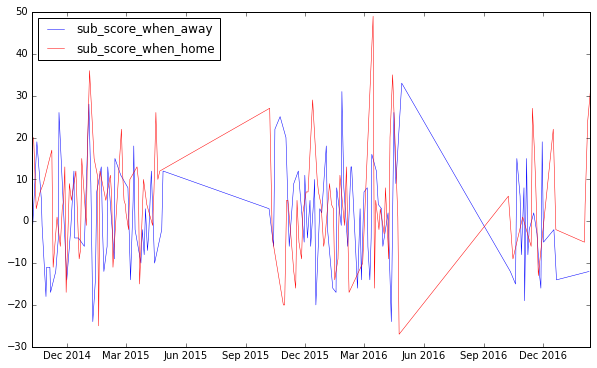

In [11]:
plot_sub_score_per_game_by_team(ah_df, " Houston Rockets")

In [12]:
ah_df['home_win_with_ah'] = np.where(ah_df['sub_score'] + ah_df['ah_1'] >= 0, 1, 0)
#ah_df['home_win_with_ah'] = ah_df['home_win']

In [22]:
judge = ah_df[ah_df['home_win_with_ah'] != ah_df['home_win']]
ah_df[(ah_df["away_team__" + str(team)] == 1)].shape[0]

121

In [46]:
def calculate_game_win_and_ah_win(df, team):
    team = team.strip().replace(' ', '_')
    total_away_games = df[(df["away_team__" + str(team)] == 1)].shape[0]
    total_home_games = df[(df["home_team__" + str(team)] == 1)].shape[0]
    total_away_games_win = total_away_games - df[(df["away_team__" + str(team)] == 1)].home_win.sum()
    total_home_games_win = df[(df["home_team__" + str(team)] == 1)].home_win.sum()
    total_away_ah_win = total_away_games - df[(df["away_team__" + str(team)] == 1)].home_win_with_ah.sum()
    total_home_ah_win = df[(df["home_team__" + str(team)] == 1)].home_win_with_ah.sum()
    
    total_games = total_away_games + total_home_games
    total_games_win = total_away_games_win + total_home_games_win
    total_ah_win = total_away_ah_win + total_home_ah_win
    
    win_game_percent = float(total_games_win)/float(total_games)
    win_ah_percent = float(total_ah_win)/float(total_games)
    # print "win games percentage: ", float(total_games_win)/float(total_games)
    # print "win ah percentage: ", float(total_ah_win)/float(total_games)
    
    return team, total_away_games, total_away_games_win, total_away_ah_win, total_home_games, total_home_games_win, total_home_ah_win


In [47]:
calculate_game_win_and_ah_win(ah_df, "Boston Celtics")

('Boston_Celtics', 123, 59, 71, 117, 69, 63)

In [37]:
team_names = ['Atlanta_Hawks',
'Boston_Celtics',
'Brooklyn_Nets',
'Charlotte_Hornets',
'Chicago_Bulls',
'Cleveland_Cavaliers',
'Dallas_Mavericks',
'Denver_Nuggets',
'Detroit_Pistons',
'Golden_State_Warriors',
'Houston_Rockets',
'Indiana_Pacers',
'Los_Angeles_Clippers',
'Los_Angeles_Lakers',
'Memphis_Grizzlies',
'Miami_Heat',
'Milwaukee_Bucks',
'Minnesota_Timberwolves',
'New_Orleans_Pelicans',
'New_York_Knicks',
'Oklahoma_City_Thunder',
'Orlando_Magic',
'Philadelphia_76ers',
'Phoenix_Suns',
'Portland_Trail_Blazers',
'Sacramento_Kings',
'San_Antonio_Spurs',
'Toronto_Raptors',
'Utah_Jazz',
'Washington_Wizards']

In [56]:
win_data = []
for i in team_names:
    win_data.append(calculate_game_win_and_ah_win(ah_df, i))
win_data = np.array(win_data)
win_data_df = pd.DataFrame(win_data, columns=['team',\
                                              'total_away_games', 'total_away_games_win', 'total_away_ah_win', \
                                              'total_home_games', 'total_home_games_win', 'total_home_ah_win'])
win_data_df['games_win_percent'] = (win_data_df['total_away_games_win'].astype(float) + win_data_df['total_home_games_win'].astype(float)) / \
                                (win_data_df['total_away_games'].astype(float) + win_data_df['total_home_games'].astype(float))
win_data_df['ah_win_percent'] = (win_data_df['total_away_ah_win'].astype(float) + win_data_df['total_home_ah_win'].astype(float)) / \
                                (win_data_df['total_away_games'].astype(float) + win_data_df['total_home_games'].astype(float))

win_data_df.ah_win_percent.describe()

count    30.000000
mean      0.499804
std       0.029811
min       0.452174
25%       0.477257
50%       0.500000
75%       0.518054
max       0.558333
Name: ah_win_percent, dtype: float64

In [60]:
win_data_df.sort_values(by=['ah_win_percent'], ascending=0)

,team,total_away_games,total_away_games_win,total_away_ah_win,total_home_games,total_home_games_win,total_home_ah_win,games_win_percent,ah_win_percent
1,Boston_Celtics,123,59,71,117,69,63,0.533333,0.558333
10,Houston_Rockets,127,68,68,115,76,64,0.595041,0.545455
8,Detroit_Pistons,122,49,62,117,64,68,0.472803,0.543933
0,Atlanta_Hawks,127,68,68,122,90,67,0.634538,0.542169
28,Utah_Jazz,116,53,65,115,63,60,0.502165,0.541126
9,Golden_State_Warriors,127,90,63,133,122,75,0.815385,0.530769
14,Memphis_Grizzlies,120,61,59,120,81,68,0.591667,0.529167
3,Charlotte_Hornets,121,51,71,114,66,51,0.497872,0.519149
7,Denver_Nuggets,121,39,65,116,55,57,0.396624,0.514768
16,Milwaukee_Bucks,123,46,66,116,62,56,0.451883,0.510460


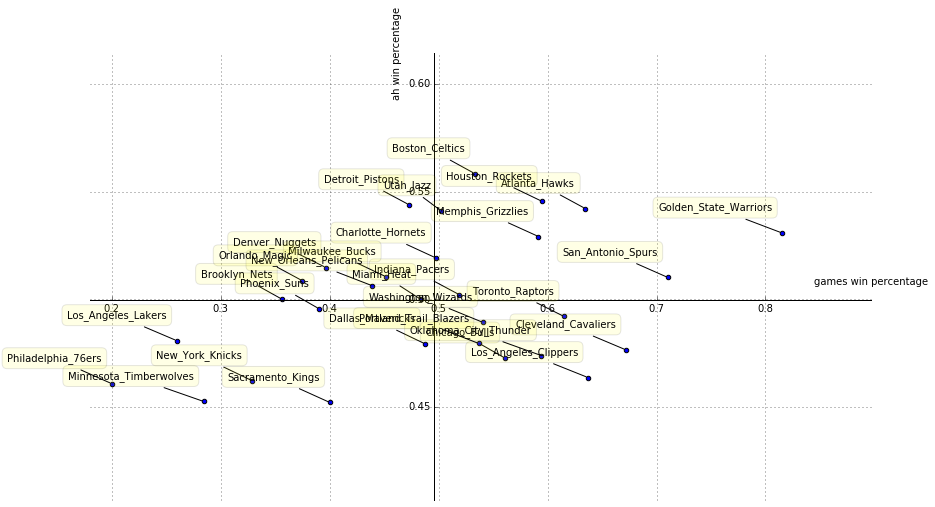

In [101]:
gwp = np.array(win_data_df.games_win_percent)
awp = np.array(win_data_df.ah_win_percent)
tn = np.array(win_data_df.team)
fig = plt.figure(figsize=(14, 8), dpi=100)
plt.xlim(gwp.min()*0.9, gwp.max()*1.1)
plt.ylim(awp.min()*0.9, awp.max()*1.1)

ax=plt.gca()

ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',np.mean(awp))) 
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',np.mean(gwp)))

ax.xaxis.set_label_coords(1, 0.5)
ax.yaxis.set_label_coords(0.4, 1)

plt.xlabel('games win percentage')
plt.ylabel('ah win percentage')
plt.legend()
plt.grid(True)

plt.scatter(gwp, awp, marker='o', cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(tn, gwp, awp):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.1),
        arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))

plt.show()